In [1]:
import sys
sys.path.append('./src')  # or appropriate relative path
from preprocess import DataPreprocessor, save_preprocessor, load_and_label_data # type: ignore
from sklearn.model_selection import train_test_split
from modeltraining import build_model, plot_confusion_matrix
from modeltraining import evaluate_model, plot_training_history
import numpy as np


In [2]:
master_dataset = load_and_label_data()
master_dataset.to_csv("data/masterset.csv",index=False)

Loading and auto-labeling normal batch files...
  - Loaded and labeled normalbatch1.csv as Normal.
  - Loaded and labeled normalbatch2.csv as Normal.
  - Loaded and labeled normalbatch3.csv as Normal.
  - Loaded and labeled normalbatch4.csv as Normal.
  - Loaded and labeled normalbatch5.csv as Normal.
  - Loaded and labeled normalbatch6.csv as Normal.
  - Loaded and labeled normalbatch7.csv as Normal.

Loading manually labeled fault batch files...
  - Loaded agitatorfault_L.csv using your manual labels.
  - Loaded runawayfault_L.csv using your manual labels.

Successfully combined all data into a master table with 5409 rows.


In [3]:
SEQUENCE_LENGTH = 30
FEATURES = [
    'ReactorTemp', 'Pressure_bar', 'Volume_m3', 'Agitator_Speed_rpm',
    'Coolant_Flow_m3_s', 'Feed_Flow_m3_s', 'Coolant_delatT_K'
]
LABEL_COLUMN = 'fault_type'

In [4]:
preprocessor_obj = DataPreprocessor(
    features=FEATURES,
    label_col=LABEL_COLUMN,
    sequence_length=SEQUENCE_LENGTH
)
X_processed, y_processed = preprocessor_obj.process(master_dataset)
# Save the preprocessor for later use (e.g., on live data)
save_preprocessor(preprocessor_obj)


Starting preprocessing with sequence length = 30...
  - Features scaled to a 0-1 range.
  - Created 5139 sequences from the data.
  - Labels have been one-hot encoded.

Preprocessing complete!

Preprocessor object saved to pkl/preprocessor.pkl


In [5]:
print("\n--- Verification ---")
print(f"Shape of the processed features (X): {X_processed.shape}")
print(f"Shape of the processed labels (y): {y_processed.shape}")

print("\nExplanation of the shapes:")
print(f" (Number of Samples, Sequence Length, Number of Features)")
print(f" {X_processed.shape[0]} 'clips' were created.")
print(f" Each clip is {X_processed.shape[1]} time steps long.")
print(f" Each time step has {X_processed.shape[2]} sensor readings.")

print(f"\n (Number of Samples, Number of Classes)")
print(f" We have {y_processed.shape[0]} labels, one for each clip.")
print(f" Each label has {y_processed.shape[1]} possible categories (Normal, Agitator, Runaway).")


--- Verification ---
Shape of the processed features (X): (5139, 30, 7)
Shape of the processed labels (y): (5139, 3)

Explanation of the shapes:
 (Number of Samples, Sequence Length, Number of Features)
 5139 'clips' were created.
 Each clip is 30 time steps long.
 Each time step has 7 sensor readings.

 (Number of Samples, Number of Classes)
 We have 5139 labels, one for each clip.
 Each label has 3 possible categories (Normal, Agitator, Runaway).


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed
    )
print(f"Data split complete: {len(X_train)} for training, {len(X_test)} for testing.")


Data split complete: 4111 for training, 1028 for testing.


In [7]:
input_shape = (X_train.shape[1], X_train.shape[2])
input_shape

(30, 7)

In [8]:
model = build_model(input_shape)

Model architecture has been built successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,947 (120.89 KB)

 Trainable params: 30,947 (120.89 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("\nStarting model training...")
    # 'epochs=10' means the model will go through the entire training dataset 10 times.
    # 'batch_size=32' means it looks at 32 samples at a time.
    # 'validation_split=0.1' uses 10% of the training data to check progress after each epoch.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
print("Model training complete.")


Starting model training...
Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7900 - loss: 0.5144 - val_accuracy: 0.9684 - val_loss: 0.1160
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9628 - loss: 0.1223 - val_accuracy: 0.9709 - val_loss: 0.0998
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9651 - loss: 0.1098 - val_accuracy: 0.9709 - val_loss: 0.0929
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9663 - loss: 0.1046 - val_accuracy: 0.9733 - val_loss: 0.0707
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9686 - loss: 0.0908 - val_accuracy: 0.9733 - val_loss: 0.0707
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9714 - loss: 0.0832 - val_accuracy: 0.9757 - val_loss: 0.0611
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9707 - loss: 0.0871 - val_accuracy: 0.9757 - val_loss: 0.0617
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9733 

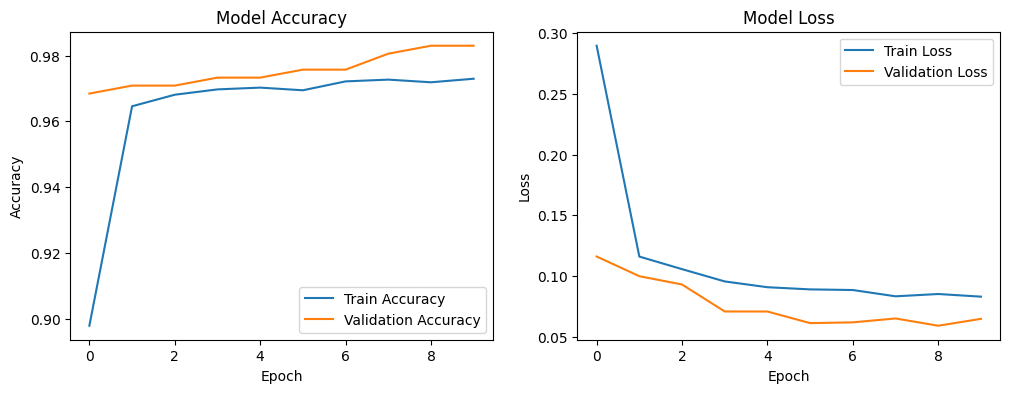

In [10]:
plot_training_history(history)

In [11]:
evaluate_model(model, X_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision: 0.9843
Recall: 0.9835
F1 Score: 0.9837


In [12]:
print("\nEvaluating model on the unseen test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"  -> Test Accuracy: {accuracy * 100:.2f}%")
print(f"  -> Test Loss: {loss:.4f}")



Evaluating model on the unseen test data...
  -> Test Accuracy: 98.35%
  -> Test Loss: 0.0744


In [13]:
print("\nGenerating confusion matrix...")
    # Get the model's predictions on the test set.
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


Generating confusion matrix...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


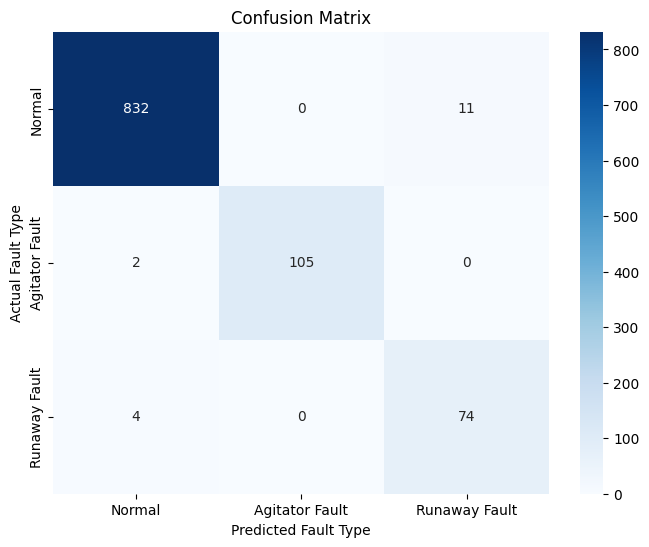

In [14]:
class_names = ['Normal', 'Agitator Fault', 'Runaway Fault']
plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)

In [15]:
model.save('models/reactor_fault_detector1.h5')
print(f"\nTrained model saved successfully to '{'models/reactor_fault_detector1.h5'}'")


Trained model saved successfully to 'models/reactor_fault_detector1.h5'
